# Football Forecasting - WDSS Demo

Instert image here.

Here we provide a baseline model for our upcoming Premier League forecasting competition.

https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/   - Main Inspiration

https://en.wikipedia.org/wiki/Skellam_distribution   - Skellam Distribution Wiki

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skellam.html  - scipy.skellam

https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling-dixon-coles-and-time-weighting/    - Dixon Coles model

https://www.imperial.ac.uk/media/imperial-college/faculty-of-engineering/computing/public/1718-ug-projects/Corentin-Herbinet-Using-Machine-Learning-techniques-to-predict-the-outcome-of-profressional-football-matches.pdf - ML Paper

https://www.youtube.com/watch?v=CF8arYimMbk&ab_channel=WarwickDataScienceSociety - Tim's Video (R)

In [1]:
# Import some modules
from scipy.stats import poisson, skellam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

In [2]:
# Fix Comments
from scipy.optimize import minimize
import seaborn as sns

# Importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Poisson Distribution

#### $ P(x) = \frac{e^{-\lambda}\lambda^{x}}{x!}, \lambda > 0 $

In [3]:
# Have an avg incidence of 1.3 per event. Size is the number of event scales.
x_rvs = pd.Series(poisson.rvs(1.3, size=100000, random_state=2))
x_rvs.mean()

1.29415

In [4]:
data = x_rvs.value_counts().sort_index().to_dict()
data

{0: 27583, 1: 35414, 2: 22723, 3: 9948, 4: 3236, 5: 855, 6: 201, 7: 34, 8: 6}

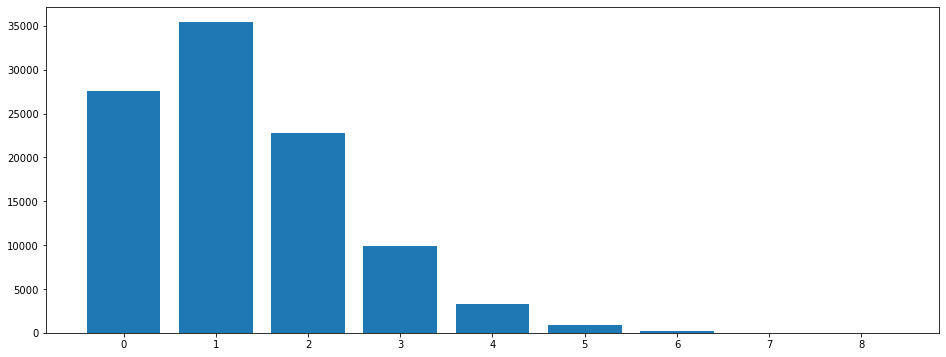

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(range(len(data)), list(data.values()))
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

In [6]:
def poisson_pmf(k, lam):
    return (lam ** k * np.exp(-lam)) / np.math.factorial(k)
poisson_pmf(0, 1.2)

0.30119421191220214

In [7]:
poisson.pmf(0, 1.2)

0.30119421191220214

In [8]:
poisson.std(1.2)

1.0954451150103321

In [9]:
season = 1819
name = {season: "epl_"+str(season)}
name[season] = 10

globals()["epl_"+str(season)] = 10
x = globals()["epl_"+str(season)]
print(x+2)

12


### Forecasting the Premier League

#### Data

In [10]:
# Define a function to quickly get data from any given EPL season.
# Current GW fixtures are only added after the GW has finished.

def get_epl_data(season):
    """
    Takes in season formatted as YYYY (last 2 digits of Y1 and Y2 - no spaces or slashes)
    """
    
    x = pd.read_csv("http://www.football-data.co.uk/mmz4281/" + str(season) + "/E0.csv")
    x = x[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']]
    x = x.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR':'Result'})
    globals()["epl_"+str(season)] = x
    
    return globals()["epl_"+str(season)]

In [11]:
epl_1718 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1718/E0.csv")
epl_1718.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA',
       'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH',
       'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5',
       'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH',
       'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

#### Add link to column names descriptiions.

In [12]:
epl_1718 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1718/E0.csv")
epl_1718 = epl_1718[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']]
epl_1718 = epl_1718.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR':'Result'})
epl_1718.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Arsenal,Leicester,4,3,H
1,Brighton,Man City,0,2,A
2,Chelsea,Burnley,2,3,A
3,Crystal Palace,Huddersfield,0,3,A
4,Everton,Stoke,1,0,H


In [13]:
epl_1617 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617 = epl_1617[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']]
epl_1617 = epl_1617.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR':'Result'})
epl_1617.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Burnley,Swansea,0,1,A
1,Crystal Palace,West Brom,0,1,A
2,Everton,Tottenham,1,1,D
3,Hull,Leicester,2,1,H
4,Man City,Sunderland,2,1,H


#### Model

In [14]:
# EPL data and the Home advantage
epl_1617 = epl_1617[:-10]
epl_1617.mean()

HomeGoals    1.591892
AwayGoals    1.183784
dtype: float64

In [15]:
# probability of draw between home and away team
skellam.pmf(0.0,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.2480937681071708

In [16]:
# probability of home team winning by one goal
skellam.pmf(1,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.22706765807563964

In [17]:
# Prepare the data
goal_model_data = pd.concat([epl_1617[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1617[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

In [18]:
# Building the model
# Poisson Regression: log-linear model
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

In [19]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1042.4
Date:                Sun, 26 Sep 2021   Deviance:                       776.11
Time:                        11:37:19   Pearson chi2:                     659.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3725      0.198      1.880      0.060      -0.016       0.761
team[T.Bournemouth]           -0.2891      0.179     -1.612      0.107      -0.641       0.062
team[T.Burnley]               -0.6458      0.200     -3.230      0.001      -1.038      -0.254
team[T.Chelsea]                0.0789      0.162      0.488      0.626      -0.238       0.396
team[T.Crystal Palace]        -0.3865      0.183     -2.107      0.035      -0.746      -0.027
team[T.Everton]               -0.2008      0.173     -1.161      0.246      -0.540       0.138
team[T.Hull]                  -0.7006      0.204     -3.441      0.001      -1.100      -0.302
team[T.Leicester]             -0.4204      0.187     -2.249      0.025      -0.787      -0.054
team[T.Liverpool]              0.0162      0.164      0.099      0.921      -0.306       0.338
team[T.Man City]               0.0117      0.164      0.072      0.943      -0.310       0.334
team[T.Man United]            -0.3572      0.181     -1.971      0.049      -0.713      -0.002
team[T.Middlesbrough]         -1.0087      0.225     -4.481      0.000      -1.450      -0.568
team[T.Southampton]           -0.5804      0.195     -2.976      0.003      -0.963      -0.198
team[T.Stoke]                 -0.6082      0.197     -3.094      0.002      -0.994      -0.223
team[T.Sunderland]            -0.9619      0.222     -4.329      0.000      -1.397      -0.526
team[T.Swansea]               -0.5136      0.192     -2.673      0.008      -0.890      -0.137
team[T.Tottenham]              0.0532      0.162      0.328      0.743      -0.265       0.371
team[T.Watford]               -0.5969      0.197     -3.035      0.002      -0.982      -0.211
team[T.West Brom]             -0.5567      0.194     -2.876      0.004      -0.936      -0.177
team[T.West Ham]              -0.4802      0.189     -2.535      0.011      -0.851      -0.109
opponent[T.Bournemouth]        0.4109      0.196      2.092      0.036       0.026       0.796
opponent[T.Burnley]            0.1657      0.206      0.806      0.420      -0.237       0.569
opponent[T.Chelsea]           -0.3036      0.234     -1.298      0.194      -0.762       0.155
opponent[T.Crystal Palace]     0.3287      0.200      1.647      0.100      -0.062       0.720
opponent[T.Everton]           -0.0442      0.218     -0.202      0.840      -0.472       0.384
opponent[T.Hull]               0.4979      0.193      2.585      0.010       0.120       0.875
opponent[T.Leicester]          0.3369      0.199      1.694      0.090      -0.053       0.727
opponent[T.Liverpool]         -0.0374      0.217     -0.172      0.863      -0.463       0.389
opponent[T.Man City]          -0.0993      0.222     -0.448      0.654      -0.534       0.335
opponent[T.Man United]        -0.4220      

In [20]:
poisson_model.predict(pd.DataFrame(data={'team': 'Chelsea', 'opponent': 'Sunderland',
                                       'home':1},index=[1]))

1    3.061662
dtype: float64

In [21]:
poisson_model.predict(pd.DataFrame(data={'team': 'Sunderland', 'opponent': 'Chelsea',
                                       'home':0},index=[1]))

1    0.409373
dtype: float64

In [22]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=8):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))


simulate_match(poisson_model, 'Chelsea', 'Sunderland')

array([[3.10848503e-02, 1.27252918e-02, 2.60469409e-03, 3.55430293e-04,
        3.63758724e-05, 2.97825846e-06, 2.03202994e-07, 1.18836823e-08,
        6.08107019e-10],
       [9.51713025e-02, 3.89605414e-02, 7.97469271e-03, 1.08820739e-03,
        1.11370623e-04, 9.11842051e-06, 6.22138870e-07, 3.63838176e-08,
        1.86181810e-09],
       [1.45691176e-01, 5.96420029e-02, 1.22079065e-02, 1.66586157e-03,
        1.70489598e-04, 1.39587604e-05, 9.52389443e-07, 5.56974744e-08,
        2.85012879e-09],
       [1.48685709e-01, 6.08678830e-02, 1.24588275e-02, 1.70010164e-03,
        1.73993837e-04, 1.42456684e-05, 9.71964830e-07, 5.68422788e-08,
        2.90871026e-09],
       [1.13806343e-01, 4.65892199e-02, 9.53617941e-03, 1.30128411e-03,
        1.33177576e-04, 1.09038551e-05, 7.43956927e-07, 4.35079601e-08,
        2.22637186e-09],
       [6.96873094e-02, 2.85280881e-02, 5.83931147e-03, 7.96818404e-04,
        8.15489427e-05, 6.67678360e-06, 4.55548919e-07, 2.66413329e-08,
        1.3

In [25]:
def simulate_match_output(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    # Predict avg goals
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    distribution = np.outer(np.array(team_pred[0]), np.array(team_pred[1])) # *multiply distributions together
    
    # Get most likely score
    global h, a
    h = np.argmax(distribution)//(max_goals + 1) 
    a = np.argmax(distribution)%(max_goals + 1) 
    output = homeTeam + ": " + str(h) + "\n" + awayTeam + ": " + str(a)
    
    return print(output)
    return(h, a)

simulate_match_output('Chelsea', 'Liverpool')
print(h)
print(a)

Chelsea: 2
Liverpool: 1
2
1


In [26]:
def simulate_match_clean(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    # Predict avg goals
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    distribution = np.outer(np.array(team_pred[0]), np.array(team_pred[1])) # *multiply distributions together
    
    # Get most likely score
    global h, a
    h = np.argmax(distribution)//(max_goals + 1) 
    a = np.argmax(distribution)%(max_goals + 1) 
    
    return(h, a)

simulate_match_clean('Chelsea', 'Liverpool')

(2, 1)

In [27]:
type(h)

numpy.int64

In [28]:
get_epl_data(1819)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Man United,Leicester,2,1,H
1,Bournemouth,Cardiff,2,0,H
2,Fulham,Crystal Palace,0,2,A
3,Huddersfield,Chelsea,0,3,A
4,Newcastle,Tottenham,1,2,A
...,...,...,...,...,...
375,Liverpool,Wolves,2,0,H
376,Man United,Cardiff,0,2,A
377,Southampton,Huddersfield,1,1,D
378,Tottenham,Everton,2,2,D


In [29]:
epl_1819['HomeTeam'][2]
pandas_test = epl_1819

pandas_test['HomePred'] = np.zeros(len(pandas_test))

pandas_test

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred
0,Man United,Leicester,2,1,H,0.0
1,Bournemouth,Cardiff,2,0,H,0.0
2,Fulham,Crystal Palace,0,2,A,0.0
3,Huddersfield,Chelsea,0,3,A,0.0
4,Newcastle,Tottenham,1,2,A,0.0
...,...,...,...,...,...,...
375,Liverpool,Wolves,2,0,H,0.0
376,Man United,Cardiff,0,2,A,0.0
377,Southampton,Huddersfield,1,1,D,0.0
378,Tottenham,Everton,2,2,D,0.0


In [30]:
get_epl_data(1617)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Burnley,Swansea,0,1,A
1,Crystal Palace,West Brom,0,1,A
2,Everton,Tottenham,1,1,D
3,Hull,Leicester,2,1,H
4,Man City,Sunderland,2,1,H
...,...,...,...,...,...
375,Liverpool,Middlesbrough,3,0,H
376,Man United,Crystal Palace,2,0,H
377,Southampton,Stoke,0,1,A
378,Swansea,West Brom,2,1,H


In [31]:
   
def simulate_test(x):
    global data
    data = x
    
    data['HomePred'] = [0] * len(data)
    data['AwayPred'] = [0] * len(data)
    
    for i in range(len(data)):
        homeTeam = data['HomeTeam'][i]
        awayTeam = data['AwayTeam'][i]
        
        simulate_match_clean(homeTeam, awayTeam)
        data.loc[i, 'HomePred'] = int(h)
        data.loc[i, 'AwayPred'] = int(a)
    
    data = pd.DataFrame.from_dict(data)
        
    return(data)

simulate_test(epl_1617)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred
0,Burnley,Swansea,0,1,A,1,1
1,Crystal Palace,West Brom,0,1,A,1,1
2,Everton,Tottenham,1,1,D,0,1
3,Hull,Leicester,2,1,H,1,1
4,Man City,Sunderland,2,1,H,2,0
...,...,...,...,...,...,...,...
375,Liverpool,Middlesbrough,3,0,H,2,0
376,Man United,Crystal Palace,2,0,H,1,0
377,Southampton,Stoke,0,1,A,1,0
378,Swansea,West Brom,2,1,H,1,1


In [32]:
data_post = data


ResultPred = []
for i in data_post['HomePred']:
    if i > data_post['AwayPred'][i]:
        ResultPred.append('H')
    elif i == data_post['AwayPred'][i]:
        ResultPred.append('D')
    else:
        ResultPred.append('A')
        
        
data_post = pd.concat([data_post, pd.Series(ResultPred)], axis=1).rename({0: 'ResultPred'}, axis =1)

    
data_post

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred,ResultPred
0,Burnley,Swansea,0,1,A,1,1,D
1,Crystal Palace,West Brom,0,1,A,1,1,D
2,Everton,Tottenham,1,1,D,0,1,A
3,Hull,Leicester,2,1,H,1,1,D
4,Man City,Sunderland,2,1,H,2,0,H
...,...,...,...,...,...,...,...,...
375,Liverpool,Middlesbrough,3,0,H,2,0,H
376,Man United,Crystal Palace,2,0,H,1,0,D
377,Southampton,Stoke,0,1,A,1,0,D
378,Swansea,West Brom,2,1,H,1,1,D


In [33]:
correctFTR = []

for i in range(len(data_post)):
    if data_post['ResultPred'][i] is str(data_post['Result'][i]):
        correctFTR.append(True)
    else:
        correctFTR.append(False)
        
data_post = pd.concat([data_post, pd.Series(correctFTR)], axis=1).rename({0: 'correctFTR'}, axis =1)

data_post

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred,ResultPred,correctFTR
0,Burnley,Swansea,0,1,A,1,1,D,False
1,Crystal Palace,West Brom,0,1,A,1,1,D,False
2,Everton,Tottenham,1,1,D,0,1,A,False
3,Hull,Leicester,2,1,H,1,1,D,False
4,Man City,Sunderland,2,1,H,2,0,H,True
...,...,...,...,...,...,...,...,...,...
375,Liverpool,Middlesbrough,3,0,H,2,0,H,True
376,Man United,Crystal Palace,2,0,H,1,0,D,False
377,Southampton,Stoke,0,1,A,1,0,D,False
378,Swansea,West Brom,2,1,H,1,1,D,False


In [34]:
# Total correct final outcomes
data_post['correctFTR'].value_counts()

False    215
True     165
Name: correctFTR, dtype: int64

In [35]:
# Make-up of outcome predictions
data_post['ResultPred'].value_counts()

D    219
H     92
A     69
Name: ResultPred, dtype: int64

In [36]:
# Most common incorrect predictions (Draws seem prety common here?!)
data_post2 = data_post[data_post['correctFTR'] == False]
data_post2['ResultPred'].value_counts()

D    168
A     24
H     23
Name: ResultPred, dtype: int64

In [37]:
# Quick accuracy rate for outcomes
accuracy_o = data_post['correctFTR'].value_counts()[1] / 380
print(accuracy_o)

0.4342105263157895


In [ ]:
correctScore = []

for i in range(len(data_post)):
    if data_post['HomeGoals'][i] == data_post['HomePred'][i] and data_post['AwayGoals'][i] == data_post['AwayPred'][i]:
        correctScore.append(True)
    elif data_post['HomeGoals'][i] == data_post['HomePred'][i]:
        correctScore.append('Home')
    elif data_post['AwayGoals'][i] == data_post['AwayPred'][i]:
        correctScore.append('Away')
    else:
        correctScore.append(False)
        
data_post = pd.concat([data_post, pd.Series(correctScore)], axis=1).rename({0: 'correctScore'}, axis =1)
data_post

In [ ]:
# Total correct final outcomes
data_post['correctScore'].value_counts()

In [ ]:
# At least one correct prediction
sum(data_post['correctScore'].value_counts()[-3:])

In [ ]:
data_post.groupby(by=['correctFTR']).count()

In [ ]:
data_post['Result'][1]

In [ ]:
data_post['ResultPred'][1]

In [ ]:
def simulate_matches(data):
    

In [ ]:
test1 = print(2)

In [ ]:
test1

In [ ]:
chelsea_sunderland = simulate_match(poisson_model, 'Chelsea', 'Sunderland', max_goals=8)

In [ ]:
# *Match the plotting functions to the max goals

# Axes labels
goals = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Plot figure
fig, ax = plt.subplots(figsize=(3, 3), dpi=400)
fig.tight_layout()
im = ax.imshow(chelsea_sunderland, cmap="winter")



# Set ticks and paremeters
ax.set_yticks(np.arange(len(goals)))
ax.set_yticklabels(goals, fontsize=5)

ax.xaxis.tick_top()
ax.set_xticklabels(goals, fontsize=5)
ax.set_xticks(np.arange(len(goals)))

ax.tick_params(axis='both', which='major', length=2, pad=1.5)

ax.set_ylabel('Home Goals', fontsize=6) # axes label (y)
ax.set_xlabel('Away Goals', fontsize=6)
ax.xaxis.set_label_position('top')

# * Set this to the Home vs Away teams
ax.set_title('Chelsea vs Sunderland Forecast',fontsize=7, y=1.1)


# *rename this variable
# Rounding probabilites to add to the plot
rounded = chelsea_sunderland.tolist()
rounded3 = []
for z in rounded:
    rounded2 = [round(x, 3) for x in z]
    rounded3.append(rounded2)
    
rounded3 = np.array(rounded3)

for i in range(len(goals)):
    for j in range(len(goals)):
        text = ax.text(j, i, rounded3[i, j],
                       ha="center", va="center", color="black", fontsize=3,
                       fontfamily='monospace')
        
# Add grid
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='both', which='minor', color='w', length=0)
ax.grid(which="minor", color="b", linestyle='-', linewidth=0.6)        



plt.show()

In [ ]:
# Trying to get out the score in an easy to read format
output_testing = chelsea_sunderland.tolist()

max_value = max(output_testing)
max_idx = output_testing.index(max_value)
print(max_idx)

def findItem(theList, item):
    return [(i, theList[i].index(item)) for i in range(len(theList)) if item in theList[i]]

print(findItem(output_testing, max_value))

In [ ]:
# Trying to get out the score in an easy to read format
output_testing = chelsea_sunderland.tolist()

max_value = max(output_testing)
max_idx = output_testing.index(max_value)
print(max_idx)

def deep_index(lst, w):
    return [(i, sub.index(w)) for (i, sub) in enumerate(lst) if w in sub]

print(deep_index(output_testing, max_value))

In [ ]:
# Getting home and away goals
x = chelsea_sunderland

# Replace 9 with variable from max number of goals (in function)

h = np.argmax(x)//9 
a = np.argmax(x)%9
print(h)
print(p)

In [ ]:
np.where(np.argmax(x))

In [ ]:
chel_sun = simulate_match(poisson_model, "Chelsea", "Sunderland", max_goals=10)
# chelsea win
np.sum(np.tril(chel_sun, -1))

In [ ]:
np.sum(np.diag(chel_sun))

In [ ]:
np.sum(np.triu(chel_sun, 1))

Adapt final model function to output the ten matches in question with a specific input? Maybe have a dictionary and then convert?

Train and testing - Refine model using some sort of RMSD to assess the quality of the predictions? Maybe use Patriciios model? That way people can also be introduced to the scoring methods.

Add odds into the mix? Try and dd xG into the mix.

Find some intersting football-specific stats - Also skim through Soccermatics

Explain the statistics behind some of the code. Also really break down and understand stats-models properly.

Automatically add the new 10 fixtures into the function - mabe from a list to start with, but maybe try and find dataset.
Then also create the pipeline allowing for probabilities to be calculated as well as the plots - a mass 5 x 2 plot space

OUTPUT
Match score
Home and Away names
probability of most likely score

then rank the outputs based on that confidence


concatenate multiple years of data?


### Functions

#### Data

Find a new dataset wit xG included.

Make a funciton to prepare the data for the model. Then Make one to concatenate the date - dictionary with names and syntax for the loop?

Look through data and tweak model using existing features.

#### Plotting

A large detailed plot function

A multiplot for the weeks ggames.


#### Validation

Build function to run prediction model through a years worth of fiixtures. Find a way to score the results. Also count number of correct results predicted.
Keep the output very simple to make quick analysis easy.
-This needs to implement the scoring code simplifier I made earlier.

As well as printing scores, the probabilities need to be as well to allow sorting.


#### Finalisation

Clean up the notebook and add comments.

Add explanatory text to the notebook. Also set up styling before commiting. 
-Efficient Market Hypothesis - Betting

Add images and unify colour palette (WDSS colours) - Stretch: WDSS cmap? linear segmented colormaps



how does the model perform across seasons